In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector

# Simulate LFP with Ripple

In [3]:
from ripple_detection.simulate import simulate_time
import scipy.stats

SAMPLING_FREQUENCY = 1000
n_samples = SAMPLING_FREQUENCY * 3
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
white_noise = np.random.normal(size=time.shape)
RIPPLE_FREQUENCY = 200
ripple_signal = np.sin(2 * np.pi * time * RIPPLE_FREQUENCY)
carrier = scipy.stats.norm(loc=1.1, scale=0.025).pdf(time)
carrier /= carrier.max()

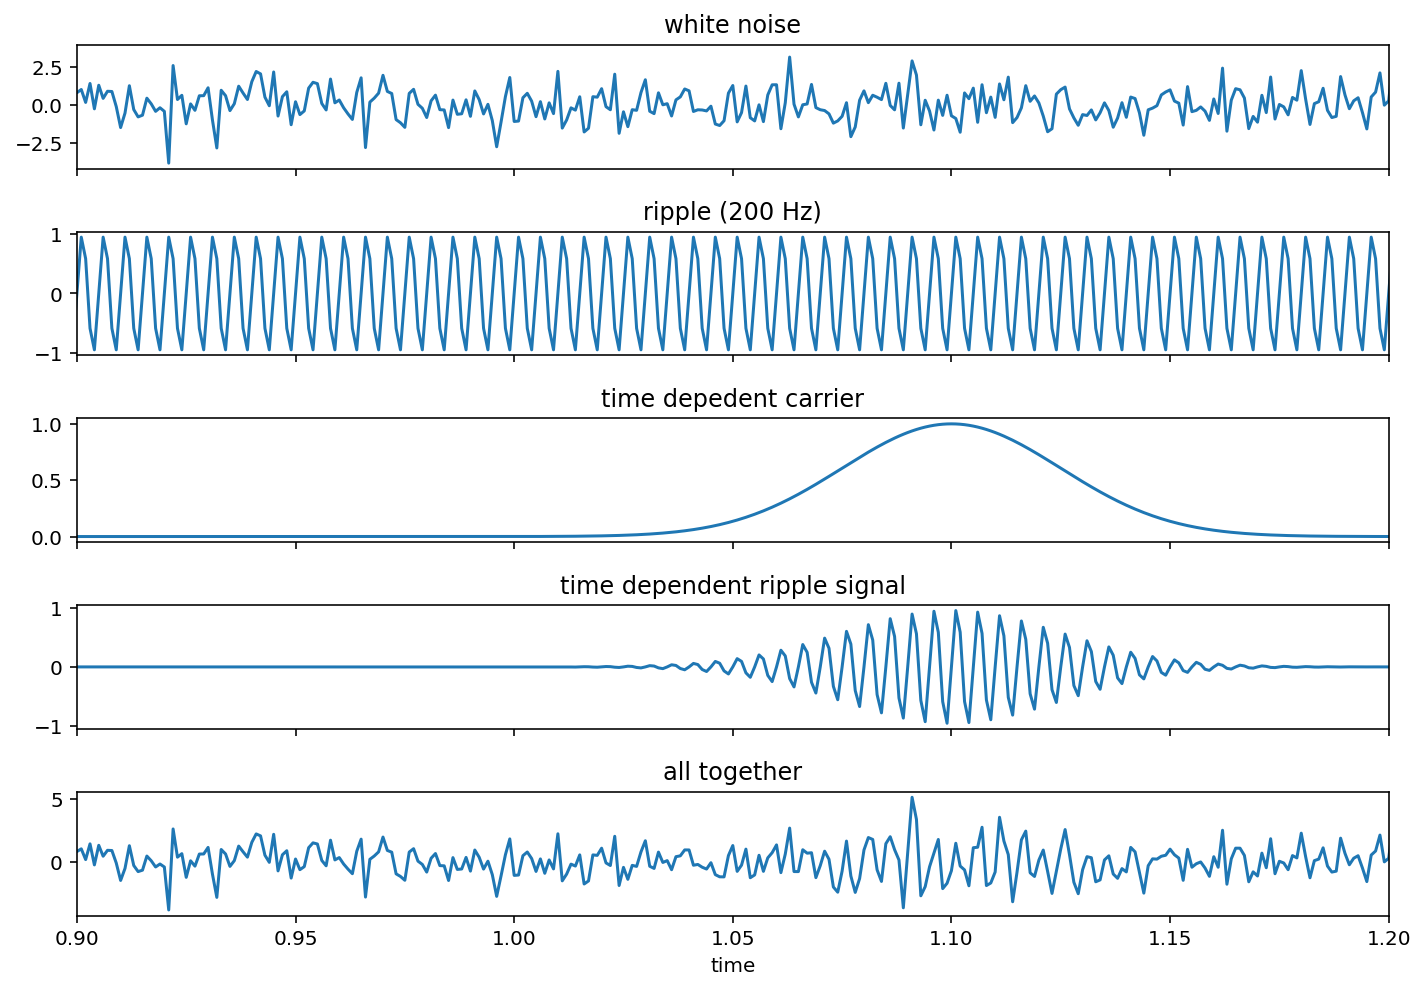

In [4]:
f, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 7))
ax[0].plot(time, white_noise)
ax[0].set_title('white noise')
ax[1].plot(time, ripple_signal)
ax[1].set_title('ripple (200 Hz)')
ax[2].plot(time, carrier)
ax[2].set_title('time depedent carrier')
ax[3].plot(time, (ripple_signal * carrier));
ax[3].set_title('time dependent ripple signal')
ax[4].plot(time, 5 / 2 * (ripple_signal * carrier) + white_noise);
ax[4].set_title('all together')
ax[4].set_xlabel('time')

plt.xlim(0.9, 1.2)
plt.tight_layout()

## Test Ripple Detectors
#### Single LFP
Simulate a single LFP with ripples at time 1.1 and time 2.1

This is with brown noise $\frac{1}{f^2}$

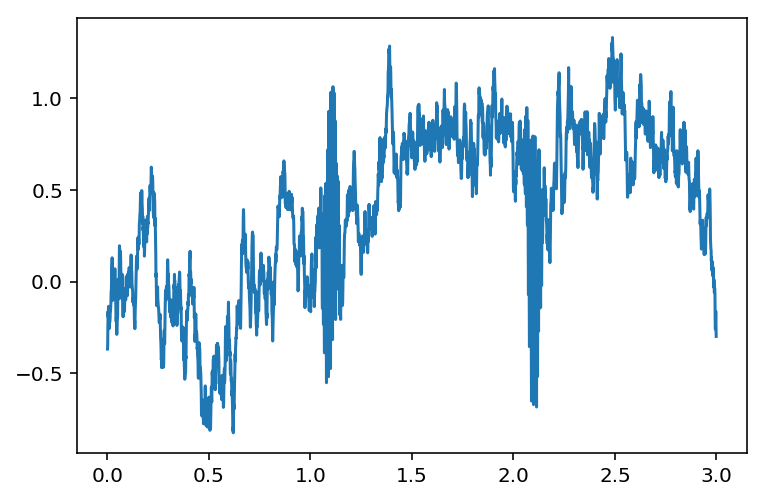

In [5]:
from ripple_detection.simulate import simulate_LFP

LFPs = simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5)[:, np.newaxis]
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,
1,1.042,1.164
2,2.041,2.154


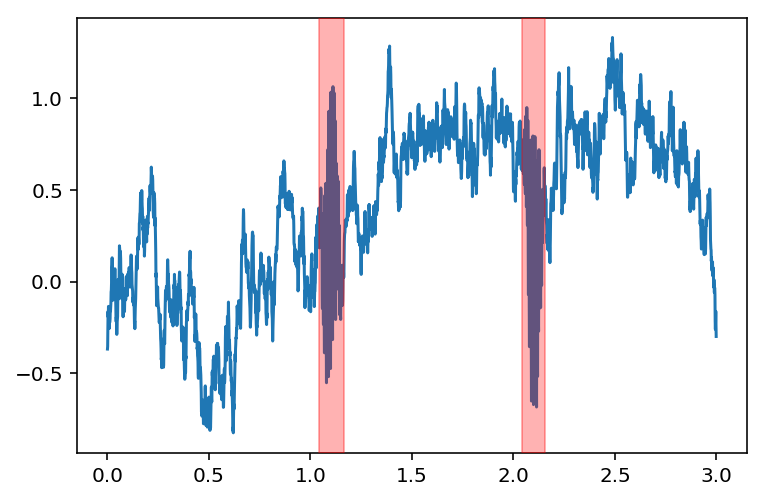

In [6]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,1.042,1.164
2,2.041,2.155


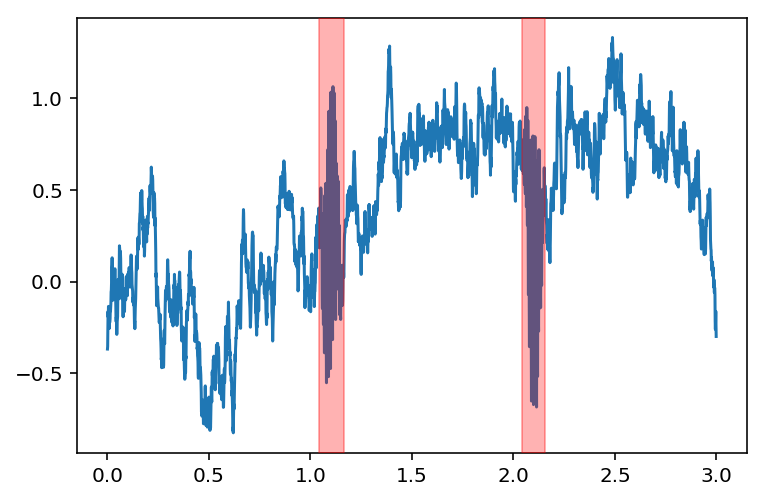

In [7]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

### Two LFPs

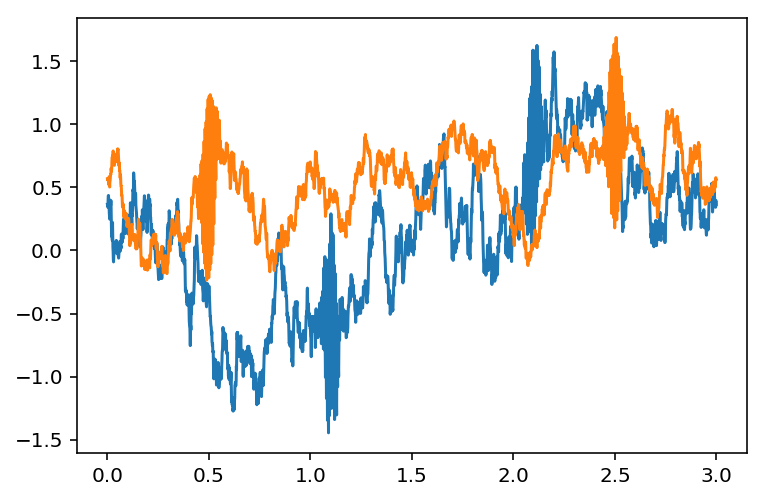

In [8]:
LFPs = np.stack((
    simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [0.5, 2.5], noise_amplitude=1.2, ripple_amplitude=1.5)
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,
1,0.438,0.559
2,1.041,1.161
3,2.042,2.157
4,2.441,2.560


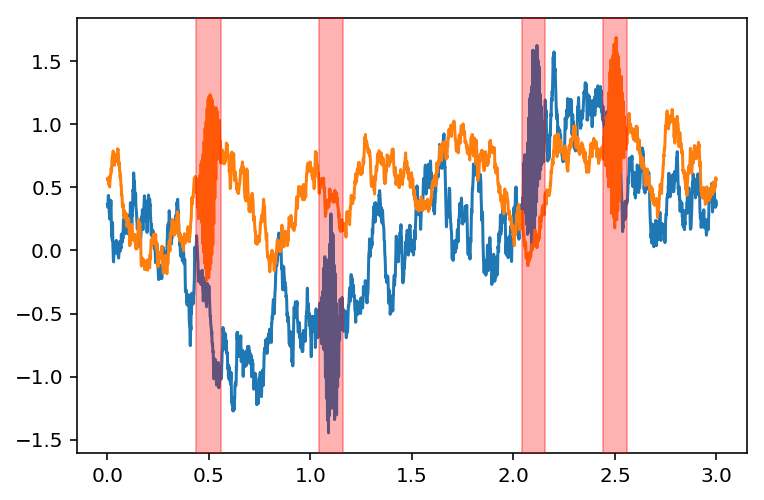

In [9]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,0.445,0.554
2,1.048,1.151
3,2.046,2.152
4,2.443,2.557


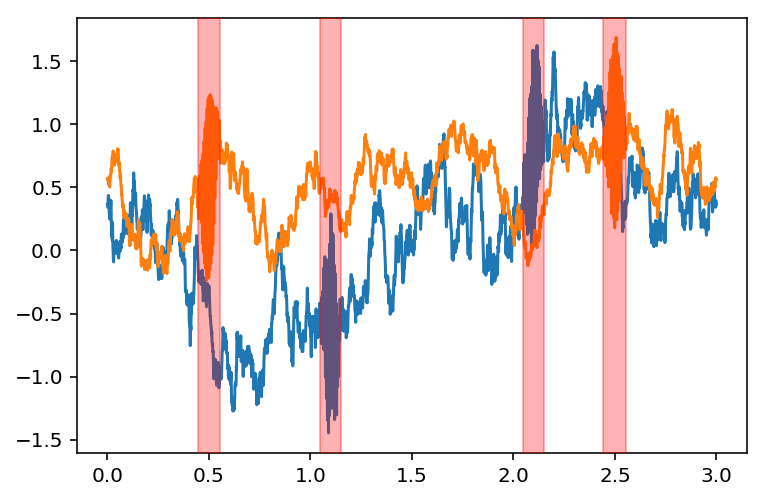

In [10]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

## Two LFPs with close ripples

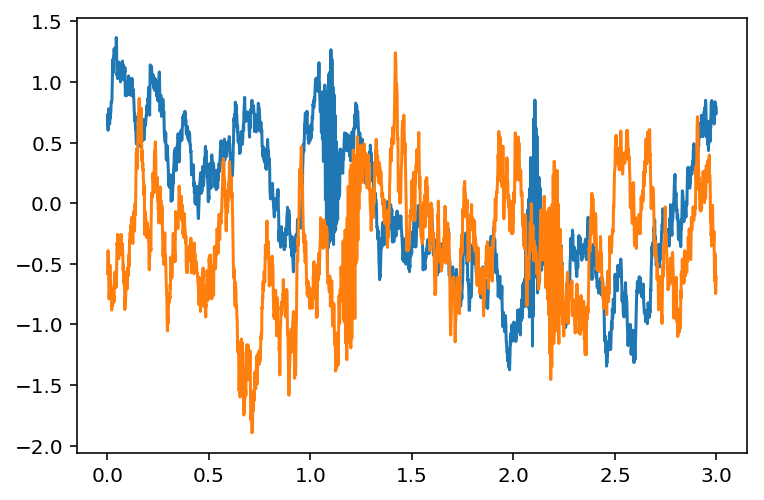

In [11]:
LFPs = np.stack((
    simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [1.2, 2.2], noise_amplitude=1.2, ripple_amplitude=1.5)
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,
1,1.047,1.253
2,2.036,2.249


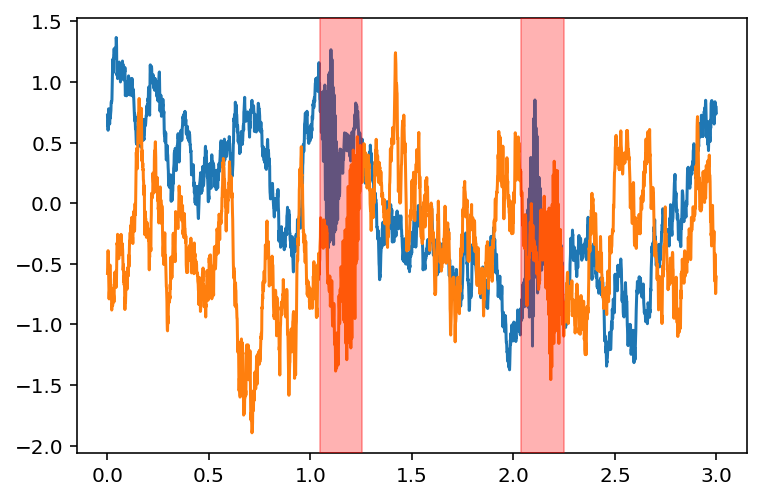

In [12]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,1.050,1.250
2,2.038,2.247


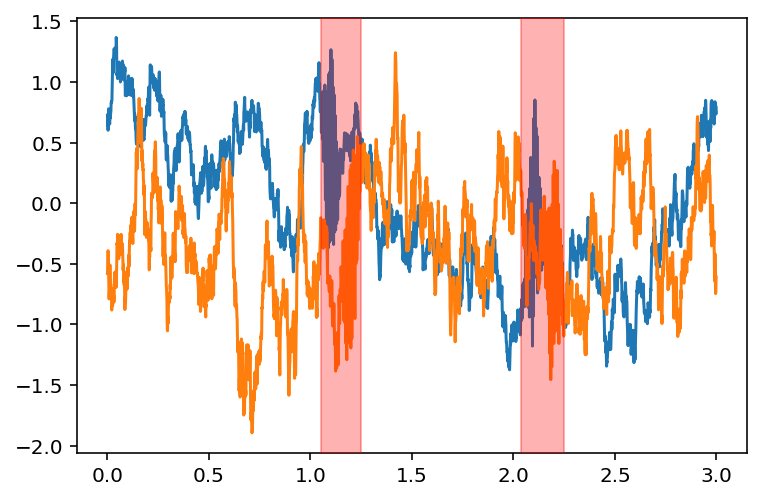

In [13]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

## Many LFPs, only two LFPs with ripples

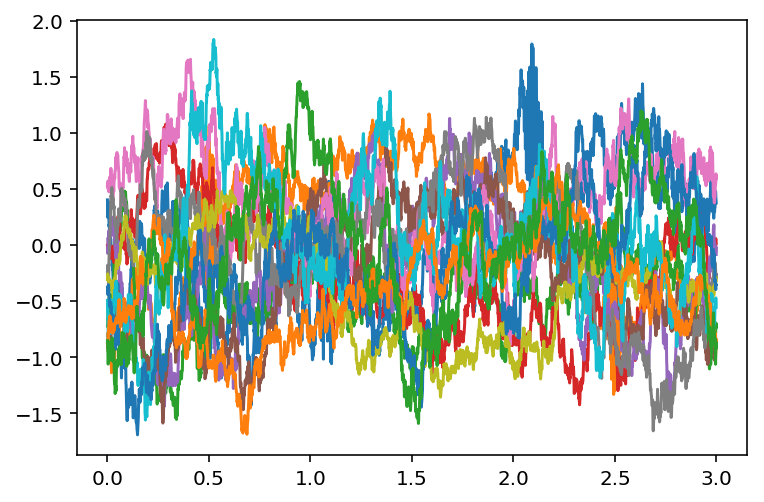

In [14]:
LFPs = np.stack((
    simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [0.5, 2.5], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,
1,0.443,0.556
2,1.044,1.157
3,2.044,2.156
4,2.443,2.556


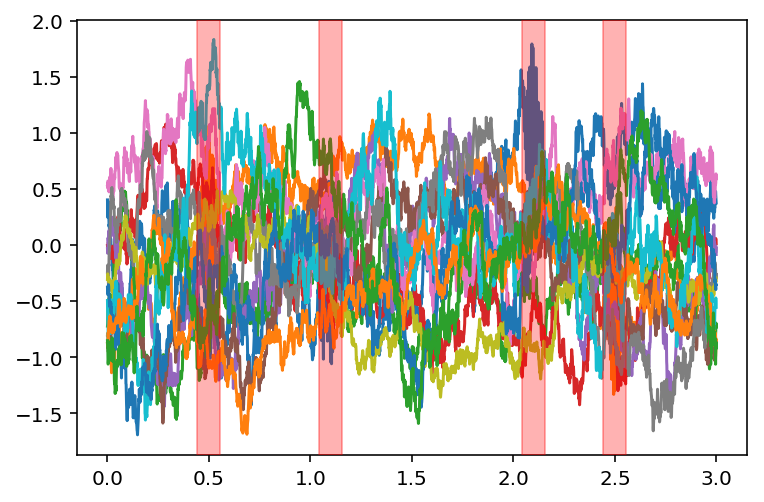

In [15]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,0.451,0.554
2,1.045,1.150
3,2.052,2.150
4,2.454,2.558


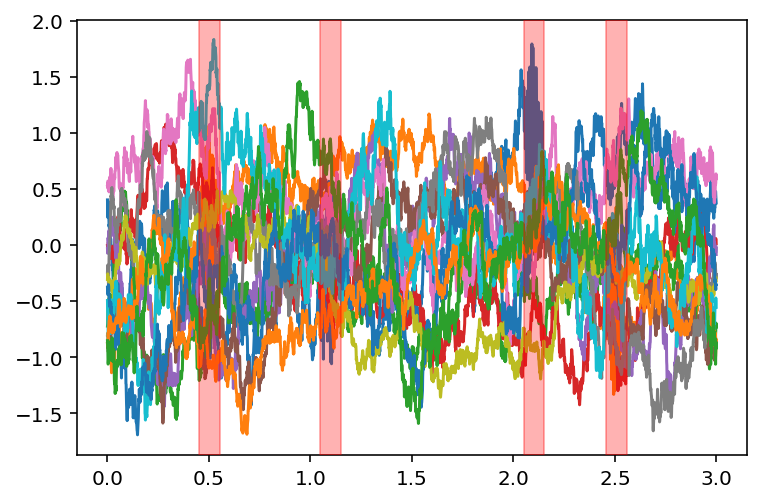

In [16]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

## Two LFPs but speed criterion is not met for second ripple

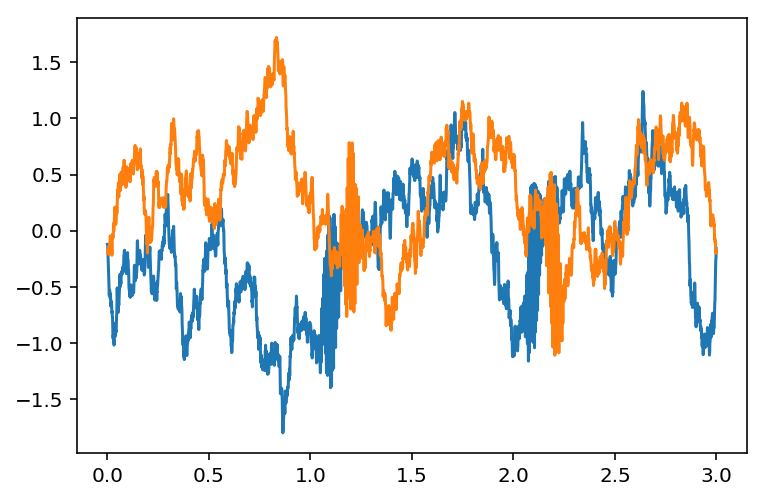

In [17]:
LFPs = np.stack((
    simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [1.2, 2.2], noise_amplitude=1.2, ripple_amplitude=1.5)
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)
speed[time > 1.5] = 5

,start_time,end_time
ripple_number,,
1,1.039,1.256


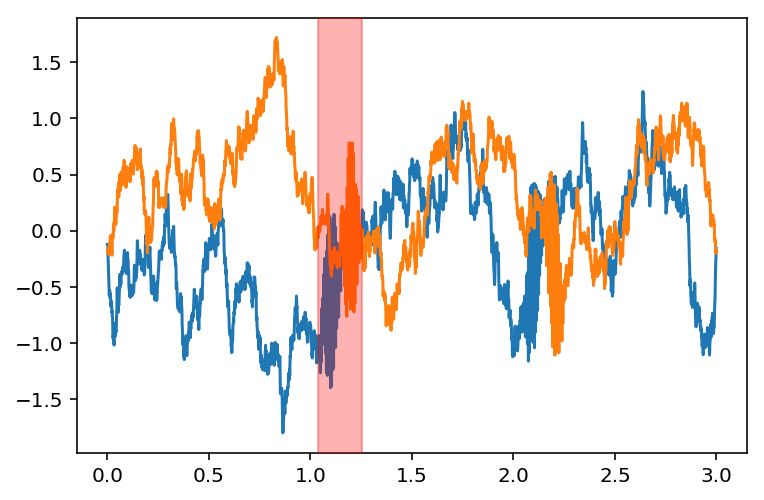

In [18]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,1.05,1.251


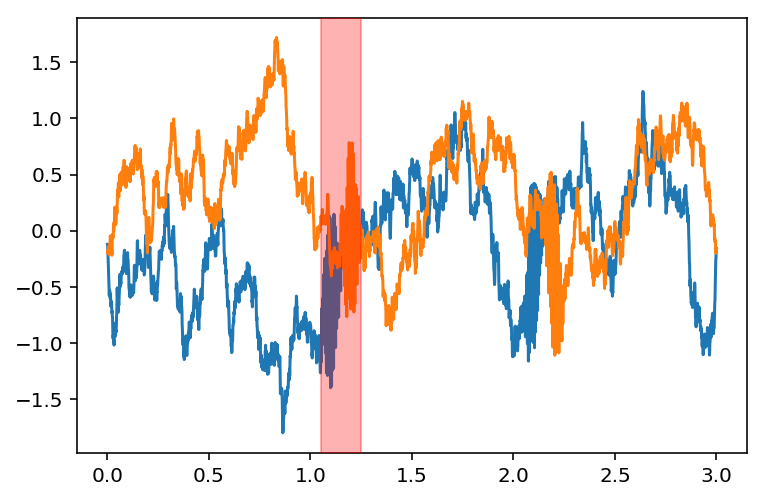

In [19]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

## Ripple but duration is too short

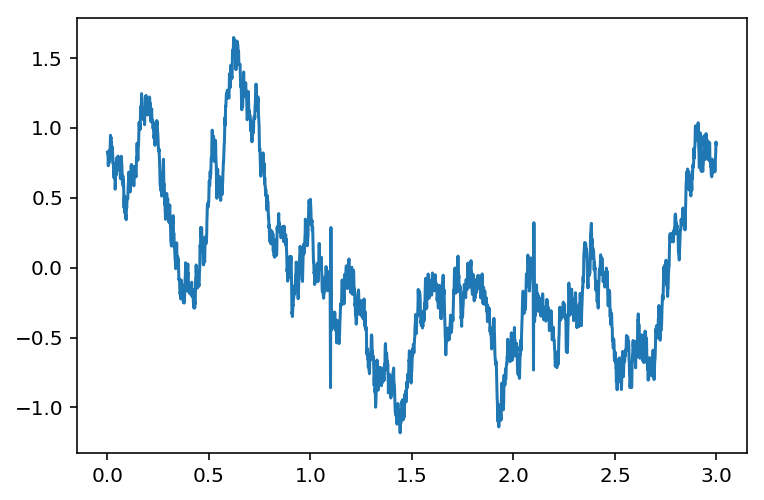

In [64]:
LFPs = np.stack((
    simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5, ripple_width=0.010),
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,
1,1.077,1.126
2,2.073,2.125


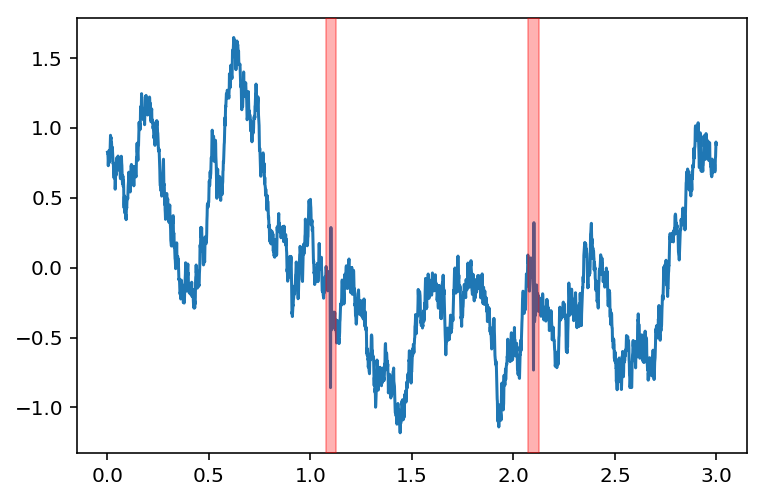

In [66]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,
1,1.077,1.127
2,2.074,2.126


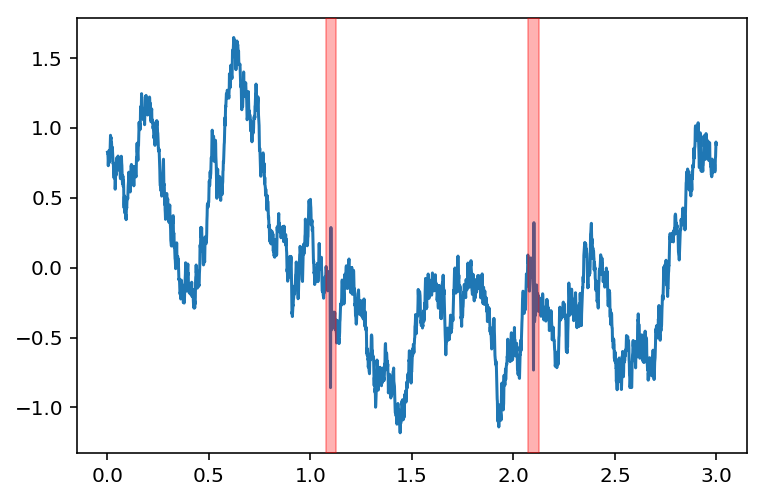

In [67]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

### NO ripple

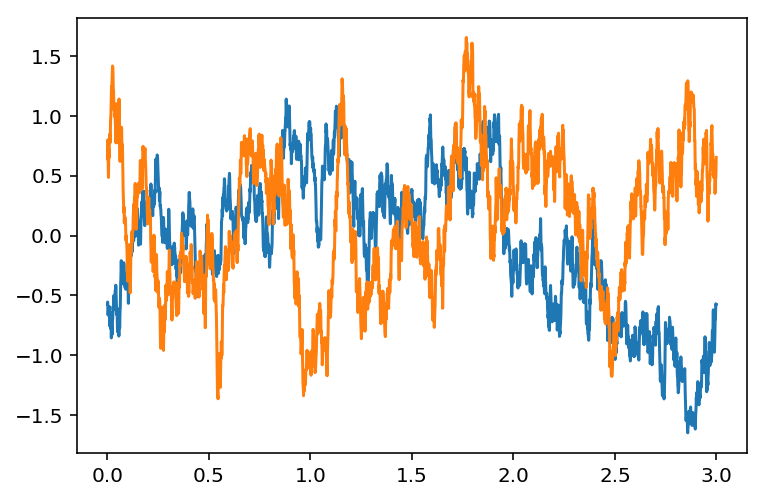

In [68]:
LFPs = np.stack((
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5)
    ), axis=1)
plt.plot(time, LFPs)
speed = np.ones_like(time)

,start_time,end_time
ripple_number,,


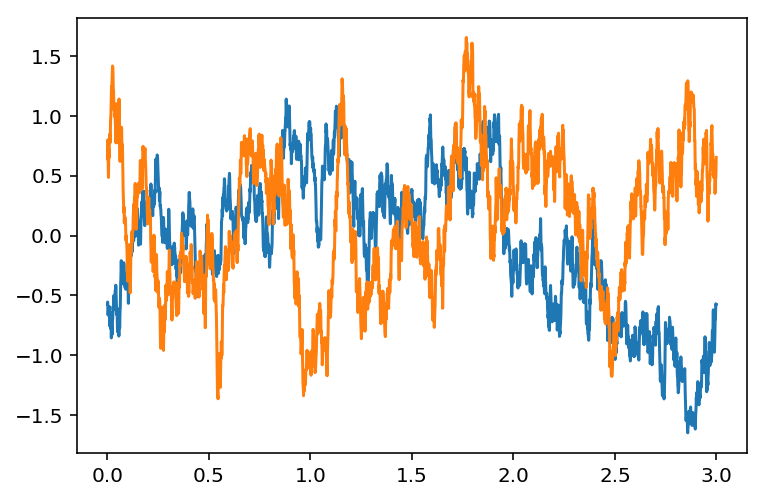

In [69]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

,start_time,end_time
ripple_number,,


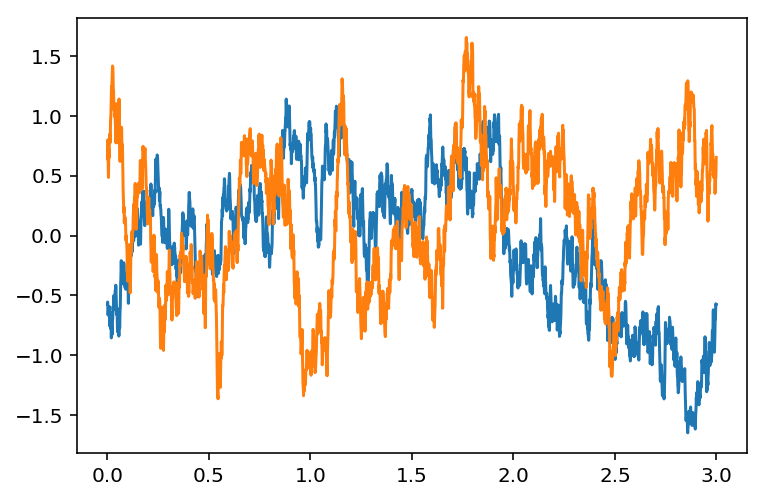

In [70]:
Kay_ripple_times = Kay_ripple_detector(time, LFPs, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, LFPs)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)